# **How Does Pre-Training (and Epochs and Batches) Affect the Performance of a Neural Network?**

## **Introduction**

In this section, we will explore how adjusting hyperparameters like **epochs** and **batch sizes** affects the performance of the neural network. Additionally, we will experiment with **pre-trained models** to compare their performance to our simple feedforward network.

To start with, the first few steps of data loading and preparation will be copied from Question 2. If you want to see explanations and reasoning for choices within the code then all the markdown sections are present in questions 1 and 2 for this first part.

One part that's been negatively affecting the models so far is the extreme outliers at the upper end of FRP. Although in the data cleaning stages of Question 1 the FRP was capped at 95%, it still seems like this is what is causing both the Random Forest Regressor and Neural Network to have lower R² scores, so to start with lets try capping the FRP at 80% and see what impact that has.

## **Importing Required Libraries**

The following libraries are used for data processing, neural network training, and visualisation:

- **`os`**: Handles file paths and directories.
- **`torch`**: PyTorch library for building and training neural networks.
- **`torch.nn`**: Contains classes for defining and training neural networks.
- **`torch.optim`**: Provides optimisation algorithms like Adam for training neural networks.
- **`pytorch_tabnet.tab_model`**: Provides the TabNet model for regression and classification tasks on tabular data.
- **`sklearn.model_selection.train_test_split`**: Splits the dataset into training and testing subsets.
- **`sklearn.preprocessing.StandardScaler`**: Standardises features by removing the mean and scaling to unit variance.
- **`sklearn.metrics`**: Provides performance metrics like MSE and R² score.
- **`pandas`**: For data manipulation and analysis.
- **`geopandas`**: Handles geographic data for plotting maps of Australia.
- **`numpy`**: Core library for numerical computing.
- **`matplotlib.pyplot`**: Creates static visualisations like plots and charts.
- **`matplotlib.colors`**: Manages colour normalisation for visualisations.
- **`seaborn`**: Built on `matplotlib`, provides high-level statistical graphics.

In [143]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## **Code Copied from Question 2**

With the inclusion of capping FRP at 80%

In [144]:
# Load the dataset (your own filename or path may be different)
dataset_path = "/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/cleaned_bushfires.csv"
df_cleaned = pd.read_csv(dataset_path)

An additional step here is to cap the FRP even lower than we have been which was 95%. This time we'll try 80%

In [145]:
# Cap the FRP values at the 80th percentile to remove extreme outliers
frp_80th = df_cleaned["frp"].quantile(0.80)
df_cleaned["frp_capped"] = df_cleaned["frp"].clip(upper=frp_80th)

# Remove rows with missing values to ensure a clean dataset for training
df_cleaned = df_cleaned.dropna()

In [146]:
# Save the cleaned dataset to a new CSV file
df_cleaned.to_csv("/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/cleaned_bushfires.csv", index=False)

In [147]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98514 entries, 0 to 98513
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      98514 non-null  float64
 1   longitude     98514 non-null  float64
 2   bright_ti4    98514 non-null  float64
 3   scan          98514 non-null  float64
 4   track         98514 non-null  float64
 5   acq_time      98514 non-null  int64  
 6   bright_ti5    98514 non-null  float64
 7   frp           98514 non-null  float64
 8   type          98514 non-null  int64  
 9   confidence_h  98514 non-null  bool   
 10  confidence_n  98514 non-null  bool   
 11  frp_capped    98514 non-null  float64
dtypes: bool(2), float64(8), int64(2)
memory usage: 7.7 MB


In [148]:
df_cleaned.head()

,latitude,longitude,bright_ti4,scan,track,acq_time,bright_ti5,frp,type,confidence_h,confidence_n,frp_capped
0,-37.48861,149.63156,341.1,0.41,0.60,304,293.7,4.4,0,False,True,4.4
1,-33.94823,151.21292,341.1,0.62,0.54,305,295.3,6.4,0,False,True,6.4
2,-34.45618,150.87723,328.5,0.33,0.55,305,298.1,2.1,2,False,True,2.1
3,-31.60223,150.15147,367.0,0.34,0.56,306,302.4,19.3,0,True,False,11.8
4,-29.26867,149.46602,367.0,0.35,0.57,306,307.0,13.6,0,True,False,11.8


In [149]:
# Define X and y
X = df_cleaned[["bright_ti4", "bright_ti5", "scan", "track", "latitude", "longitude"]]  # Features
y = df_cleaned["frp_capped"]  # Target variable

In [150]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [152]:
# Convert X_train and y_train to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Features
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Target

# Convert X_test and y_test to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Features
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Target

In [153]:
# Convert the training and testing data into PyTorch Tensors and then into TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)  # Create a dataset for training from features and labels
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)     # Create a dataset for testing from features and labels

# Set the batch size for training and testing
batch_size = 64

# Create DataLoader instances to handle batching and shuffling of data for more efficient training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle the training data for each epoch
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle test data (used for evaluation)

In [154]:
# Define a simple feedforward neural network for predicting continuous values (regression)
class FRP_Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FRP_Regressor, self).__init__()
        # Define the layers of the network: input layer, hidden layer, and output layer
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Transform input features to hidden layer
            nn.ReLU(),                         # Apply ReLU activation to the hidden layer
            nn.Dropout(p=0.2),  # Adding dropout with 50% probability
            nn.Linear(hidden_dim, 1)            # Output a single continuous value for regression
        )

    def forward(self, x):
        # Define how data passes through the network during forward propagation
        return self.fc(x)

# Set the input size and hidden layer size
input_dim = X_train.shape[1]  # The number of features in the dataset
hidden_dim = 64               # Number of neurons in the hidden layer

# Initialise the model with the chosen parameters
model = FRP_Regressor(input_dim, hidden_dim)

criterion = nn.MSELoss()  # Using Mean Squared Error for regression
optimiser = optim.Adam(model.parameters(), lr=0.01)

In [155]:
train_losses = []  # Store the training loss at each epoch
test_losses = []   # Store the test (validation) loss at each epoch

# Training the neural network for 50 epochs
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    
    # Forward pass: Pass the training data through the model to get predictions
    predictions = model(X_train_tensor)
    
    # Calculate the loss by comparing the predictions to the true values
    loss = criterion(predictions, y_train_tensor)
    
    # Backward pass: Zero out previous gradients, calculate new gradients, and update the model parameters
    optimiser.zero_grad()  # Zero gradients for the next step
    loss.backward()        # Perform backpropagation to calculate gradients
    optimiser.step()       # Update the model parameters
    
    # Store the loss for this epoch
    train_losses.append(loss.item())

    # Evaluate on test data (validation data)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for evaluation
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
    
    # Store the test loss for this epoch
    test_losses.append(test_loss.item())

    # Print the average loss for every epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 48.7219
Epoch [2/50], Loss: 46.1054
Epoch [3/50], Loss: 43.5696
Epoch [4/50], Loss: 41.1177
Epoch [5/50], Loss: 38.7149
Epoch [6/50], Loss: 36.3400
Epoch [7/50], Loss: 34.0030
Epoch [8/50], Loss: 31.7160
Epoch [9/50], Loss: 29.4204
Epoch [10/50], Loss: 27.1419
Epoch [11/50], Loss: 24.9159
Epoch [12/50], Loss: 22.7204
Epoch [13/50], Loss: 20.6260
Epoch [14/50], Loss: 18.5802
Epoch [15/50], Loss: 16.6861
Epoch [16/50], Loss: 14.8720
Epoch [17/50], Loss: 13.2459
Epoch [18/50], Loss: 11.7813
Epoch [19/50], Loss: 10.5427
Epoch [20/50], Loss: 9.5245
Epoch [21/50], Loss: 8.7375
Epoch [22/50], Loss: 8.1950
Epoch [23/50], Loss: 7.9302
Epoch [24/50], Loss: 7.8032
Epoch [25/50], Loss: 7.9123
Epoch [26/50], Loss: 8.0362
Epoch [27/50], Loss: 8.2314
Epoch [28/50], Loss: 8.3637
Epoch [29/50], Loss: 8.4369
Epoch [30/50], Loss: 8.3922
Epoch [31/50], Loss: 8.2180
Epoch [32/50], Loss: 7.9809
Epoch [33/50], Loss: 7.6938
Epoch [34/50], Loss: 7.3835
Epoch [35/50], Loss: 7.0617
Epoch [36/

In [156]:
torch.save(model.state_dict(), "frp_regressor.pth")
print("frp_regressor.pth saved")

frp_regressor.pth saved


## **Evaluating the Neural Network With FRP Capped Lower**

In [157]:
# Evaluate the model on the training and test data
train_loss = criterion(model(X_train_tensor), y_train_tensor)
test_loss = criterion(model(X_test_tensor), y_test_tensor)

# Print the loss on both the training and test data
print(f"Training Loss (MSE): {train_loss.item():.4f}")
print(f"Test Loss (MSE): {test_loss.item():.4f}")

# Make predictions on the test data
y_pred = model(X_test_tensor).detach().numpy()

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Training Loss (MSE): 5.7578
Test Loss (MSE): 5.6626
RMSE: 2.38
R²: 0.67


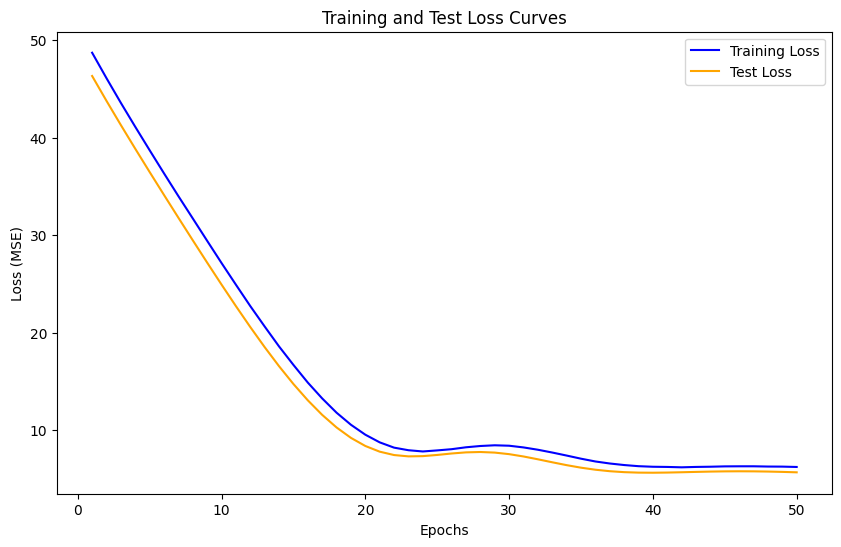

In [158]:
# Plotting the training and test loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()

As we can see that capping of FRP at 80% has greatly improved the model's performance, lowering both **MSE** and **RMSE**, as well as increasing **R²**. From now on we'll continue using this capped FRP.

## **Training the Feedforward Neural Network with Different Batch Sizes and Epochs**

In [159]:
batch_sizes = [16, 32, 64, 128, 256]  # Various batch sizes
epochs_values = [10, 20, 50, 100]  # Various numbers of epochs

results = []
train_losses = []
test_losses = []

# Loop through batch sizes and epochs
for batch_size in batch_sizes:
    for epochs in epochs_values:
        # Rebuild the model for each combination of batch size and epochs
        input_dim = X_train.shape[1]  # Number of features in the dataset
        hidden_dim = 64  # Number of neurons in the hidden layer

        # Initialise the model with the chosen parameters
        model = FRP_Regressor(input_dim, hidden_dim)

        criterion = nn.MSELoss()  # Using Mean Squared Error for regression
        optimiser = optim.Adam(model.parameters(), lr=0.01)

        train_losses = []  # Store the training loss at each epoch
        test_losses = []   # Store the test (validation) loss at each epoch

        print(f"Training model with {epochs} epochs and batch size {batch_size}...\n")

        # Train the neural network for the current combination of epochs and batch size
        for epoch in range(epochs):
            model.train()  # Set the model to training mode
            
            # Forward pass: Pass the training data through the model to get predictions
            predictions = model(X_train_tensor)
            
            # Calculate the loss by comparing the predictions to the true values
            loss = criterion(predictions, y_train_tensor)
            
            # Backward pass: Zero out previous gradients, calculate new gradients, and update the model parameters
            optimiser.zero_grad()  # Zero gradients for the next step
            loss.backward()        # Perform backpropagation to calculate gradients
            optimiser.step()       # Update the model parameters
            
            # Store the loss for this epoch
            train_losses.append(loss.item())

            # Evaluate on test data (validation data)
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():  # Disable gradient tracking for evaluation
                test_predictions = model(X_test_tensor)
                test_loss = criterion(test_predictions, y_test_tensor)
            
            # Store the test loss for this epoch
            test_losses.append(test_loss.item())

        # Store the results for this combination
        results.append({
            'batch_size': batch_size,
            'epochs': epochs,
            'final_test_loss': test_losses[-1],
            'train_losses': train_losses,
        })

# Convert results into a DataFrame for better viewing
results_df = pd.DataFrame(results)


Training model with 10 epochs and batch size 16...

Training model with 20 epochs and batch size 16...

Training model with 50 epochs and batch size 16...

Training model with 100 epochs and batch size 16...

Training model with 10 epochs and batch size 32...

Training model with 20 epochs and batch size 32...

Training model with 50 epochs and batch size 32...

Training model with 100 epochs and batch size 32...

Training model with 10 epochs and batch size 64...

Training model with 20 epochs and batch size 64...

Training model with 50 epochs and batch size 64...

Training model with 100 epochs and batch size 64...

Training model with 10 epochs and batch size 128...

Training model with 20 epochs and batch size 128...

Training model with 50 epochs and batch size 128...

Training model with 100 epochs and batch size 128...

Training model with 10 epochs and batch size 256...

Training model with 20 epochs and batch size 256...

Training model with 50 epochs and batch size 256...

T

In [160]:
final_results_df = results_df.drop(columns=['train_losses'])

pd.set_option('display.max_rows', None)
print(final_results_df.to_string(index=False))

 batch_size  epochs  final_test_loss
         16      10        26.209141
         16      20         9.532934
         16      50         5.904189
         16     100         5.122662
         32      10        27.030674
         32      20         9.987658
         32      50         5.816092
         32     100         5.113111
         64      10        22.468458
         64      20         8.293854
         64      50         5.670214
         64     100         5.095029
        128      10        23.014721
        128      20         7.889420
        128      50         5.980798
        128     100         5.200602
        256      10        26.913275
        256      20        10.463118
        256      50         5.721421
        256     100         5.105977


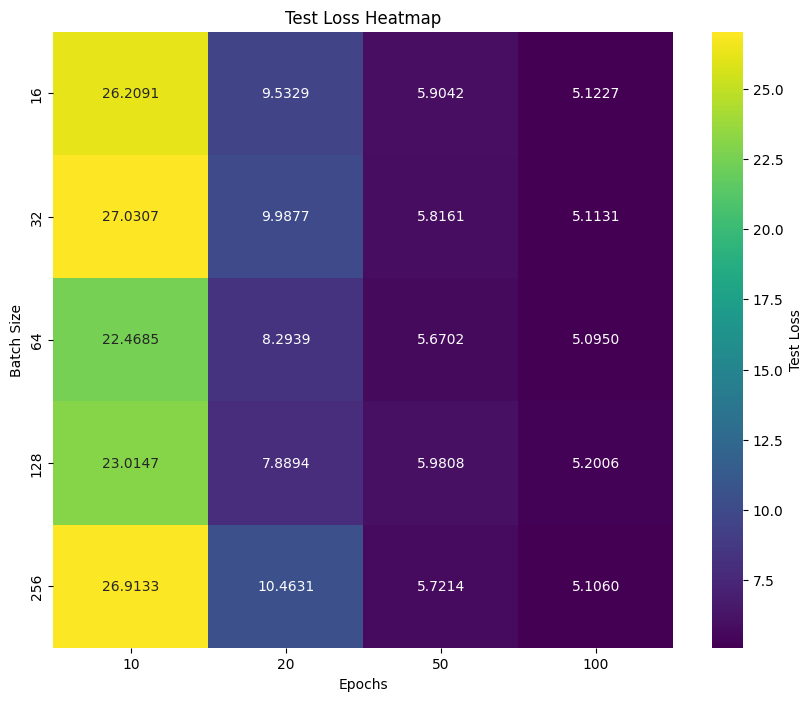

In [161]:
test_loss_matrix = results_df.pivot(index="batch_size", columns="epochs", values="final_test_loss")

# Create a heatmap for test loss
plt.figure(figsize=(10, 8))
sns.heatmap(test_loss_matrix, annot=True, cmap="viridis", fmt=".4f", cbar_kws={'label': 'Test Loss'})
plt.title("Test Loss Heatmap")
plt.xlabel("Epochs")
plt.ylabel("Batch Size")
plt.show()


In [162]:
# Initialise TabNetRegressor
model = TabNetRegressor(
    n_d=8,  # Number of decision steps
    n_a=8,  # Attention size
    n_steps=3,  # Number of steps
    gamma=1.3,  # Penalty for complexity
    lambda_sparse=1e-5,  # Sparsity loss
    optimizer_fn=torch.optim.Adam,  # Optimiser
    optimizer_params=dict(lr=1e-2),  # Learning rate
    mask_type='sparsemax'  # Sparsemax activation
)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [163]:
# Convert y_train and y_test to a numpy array and reshape it to be accepted by TabNet
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

In [164]:
train_loss = []
test_loss = []

model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)], 
    max_epochs=20,               # Number of epochs
    batch_size=64,               # Batch size
    virtual_batch_size=32,       # Virtual batch size for efficient training
    patience=10,                 # Early stopping after 10 epochs without improvement
    loss_fn=torch.nn.MSELoss(),               # MSE loss for regression
)

# Store the final training and test loss
train_loss = model.history['loss'][-1]  # Last training loss
test_loss = model.history['val_0_mse'][-1]  # Last test loss

# Print the final losses
print(f"Final Training Loss (MSE): {train_loss:.4f}")
print(f"Final Test Loss (MSE): {test_loss:.4f}")

epoch 0  | loss: 6.17072 | val_0_mse: 4.98301 |  0:00:07s
epoch 1  | loss: 5.23238 | val_0_mse: 5.17537 |  0:00:14s
epoch 2  | loss: 5.14115 | val_0_mse: 4.69676 |  0:00:21s
epoch 3  | loss: 5.08554 | val_0_mse: 4.86971 |  0:00:27s
epoch 4  | loss: 5.04873 | val_0_mse: 4.75581 |  0:00:34s
epoch 5  | loss: 5.0513  | val_0_mse: 4.71569 |  0:00:41s
epoch 6  | loss: 5.04214 | val_0_mse: 4.66371 |  0:00:48s
epoch 7  | loss: 5.02267 | val_0_mse: 4.90494 |  0:00:55s
epoch 8  | loss: 4.99883 | val_0_mse: 4.80408 |  0:01:01s
epoch 9  | loss: 5.00462 | val_0_mse: 4.77772 |  0:01:08s
epoch 10 | loss: 4.97545 | val_0_mse: 4.73304 |  0:01:15s
epoch 11 | loss: 4.99262 | val_0_mse: 4.62842 |  0:01:22s
epoch 12 | loss: 4.96831 | val_0_mse: 4.68045 |  0:01:28s
epoch 13 | loss: 4.96207 | val_0_mse: 4.6532  |  0:01:36s
epoch 14 | loss: 4.95071 | val_0_mse: 4.61894 |  0:01:42s
epoch 15 | loss: 4.9441  | val_0_mse: 4.66511 |  0:01:49s
epoch 16 | loss: 4.95037 | val_0_mse: 4.63505 |  0:01:56s
epoch 17 | los

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Final Training Loss (MSE): 4.9371
Final Test Loss (MSE): 4.6277


In [165]:
# Evaluate the model on the training and test data
train_predictions = model.predict(X_train)  # Using the TabNet model's predict method
test_predictions = model.predict(X_test)    # Same here for test predictions

# Calculate the loss using MSE (Mean Squared Error) for both training and test sets
train_loss = mean_squared_error(y_train, train_predictions)
test_loss = mean_squared_error(y_test, test_predictions)

# Print the loss on both the training and test data
print(f"Training Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")

# Calculate RMSE and R² score for the test data
rmse = np.sqrt(test_loss)
r2 = r2_score(y_test, test_predictions)

# Print RMSE and R²
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Training Loss (MSE): 4.7546
Test Loss (MSE): 4.6064
RMSE: 2.15
R²: 0.73


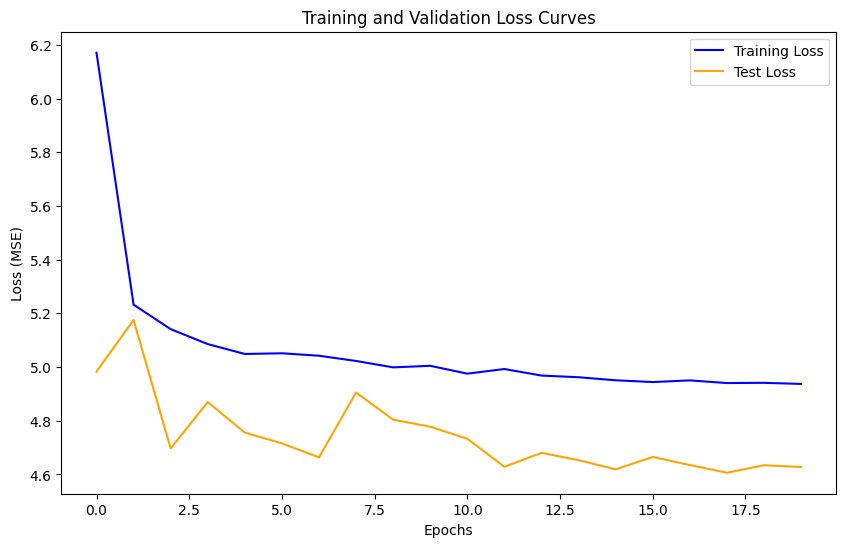

In [167]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(model.history['loss'], label='Training Loss', color='blue')
plt.plot(model.history['val_0_mse'], label='Test Loss', color='orange')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Curves')
plt.legend()

# Display the plot
plt.show()